# Prelimnary Evaluation

In [1]:
# --- One Time Setup ---
import os

# Ensure setup is only done once
try:
    if SETUP_IS_DONE:
        print("Skipping Setup")
except:
    # Perform Setup
    
    # Path to NaxRiscv repository
    path_results = os.getcwd()
    path_nax_repo = os.getcwd() + "/../"
    path_benchmarker = path_nax_repo + "/ext/NaxSoftware/baremetal/benchmarker/"
    
    # Fix because /bin is automatically added to the start of the PATH by default & messes up some verilator stuff
    # TODO: Is this really required?
    os.environ["PATH"] = os.environ["PATH"].split(":",1)[1]

SETUP_IS_DONE = True

In [ ]:
# --- Perform Benchmarks ---
import numpy as np
import pandas as pd
import os
import re
import subprocess
import time
import datetime

# Which configurations to use for the individual benchmarks
bench_worker_num = [0, 1, 2, 3, 4, 5, 6, 7] # 0-8 for both
bench_mem_max_transactions = [1, 2, 4, 8, 16, 32] # 
bench_mem_resp_time = [0, 
                       70,  # On FPGA
                       281  # On ASIC
                       ] # differs on FPGA and ASIC, computed by latency and clock freq

# performs the benchmarks
print("Starting benchmarks...")
num_bench = len(bench_worker_num) * len(bench_mem_max_transactions) * len(bench_mem_resp_time)
bench_ctr = 0
start_time = time.time()
data_lines = []
for worker_num in bench_worker_num:
    # Compile the benchmarker
    print(f"  Compiling benchmarker for {worker_num} workers")
    os.chdir(path_benchmarker)
    subprocess.run(["make", "clean"], check=True)
    subprocess.run(["make", f"WORKER_NUM={worker_num}"], check=True, capture_output=True)
    
    # Run with different configurations
    for mem_max_transactions in bench_mem_max_transactions:
        for mem_resp_time in bench_mem_resp_time:
            bench_ctr += 1
            print(f"    Running benchmark [{bench_ctr}/{num_bench}] with {worker_num} workers, {mem_max_transactions} max-trans, {mem_resp_time} resp-time")
            os.chdir(path_nax_repo)
            result = subprocess.run(["sbt", f"runMain naxriscv.platform.rtccidemo.SocSim \
                                    --load-elf {path_benchmarker}/build/benchmarker.elf \
                                    --xlen 32 \
                                    --nax-count 8 \
                                    --mem-max-trans {mem_max_transactions} \
                                    --mem-resp-time {mem_resp_time} \
                                    --no-rvls \
                                    --trace"], check=True, capture_output=True)
            buffer_size = re.search(rb"BufferSize: [^=]*= (\d*)", result.stdout).group(1)
            cycles = re.search(rb"Cycles: [^=]*= (\d*)", result.stdout).group(1)
            print("    " + result.stdout.splitlines()[-1].decode("utf-8"))
            data_lines += [[worker_num, mem_max_transactions, mem_resp_time, int(buffer_size), int(cycles)]]
        
        # Save partial progress, just in case
        df_p = pd.DataFrame(data_lines, columns=["WorkerNum", "MemMaxTransaction", "MemResponseTime", "BufferSize", "Cycles"])
        df_p.to_csv(path_results + f"/benchmark_results_partial_2.csv", index=False)
elapsed_time = time.time() - start_time

df = pd.DataFrame(data_lines, columns=["WorkerNum", "MemMaxTransaction", "MemResponseTime", "BufferSize", "Cycles"])
df.to_csv(path_results + f"/benchmark_results_2.csv", index=False)

print(f"Benchmark completed in {int(elapsed_time // 60)} min {round(elapsed_time % 60, 2)} s")
print("Result saved to " + path_results + f"/benchmark_results_2.csv")

In [68]:
# --- Load benchmark data ---
import pandas as pd
import matplotlib.pyplot as plt



data = pd.read_csv(path_results + f"/benchmark_results.csv")
data["Bandwidth"] = data["BufferSize"] / data["Cycles"] / 64 # Only every 64th byte in the buffer is read
data["MemConf"] = data["MemMaxTransaction"].astype(str) + "-MaxTrans " +  data["MemResponseTime"].astype(str) + "-RespTime"
data

,WorkerNum,MemMaxTransaction,MemResponseTime,BufferSize,Cycles,Bandwidth,MemConf
0,0,1,0,65536,27790,0.036848,1-MaxTrans 0-RespTime
1,0,1,4,65536,32442,0.031564,1-MaxTrans 4-RespTime
2,0,1,8,65536,34428,0.029743,1-MaxTrans 8-RespTime
3,0,1,16,65536,39120,0.026176,1-MaxTrans 16-RespTime
4,0,2,0,65536,28073,0.036476,2-MaxTrans 0-RespTime
...,...,...,...,...,...,...,...
155,7,8,16,65536,265146,0.003862,8-MaxTrans 16-RespTime
156,7,16,0,65536,85487,0.011978,16-MaxTrans 0-RespTime
157,7,16,4,65536,98589,0.010387,16-MaxTrans 4-RespTime
158,7,16,8,65536,131511,0.007786,16-MaxTrans 8-RespTime


In [81]:
default_color_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
def plot_benchmark(data, plots_by, groups_by, color_list=default_color_list):
    for (conf, benchmarks) in data.groupby(plots_by):
        fig, ax = plt.subplots()
        color_number = 0
        for (resp_time, bench) in benchmarks.groupby(groups_by):
            bench.plot(
                x="WorkerNum",
                y="Bandwidth",
                ylabel="Bandwidth (cacheline/cycle)",
                title=str(conf) + " " + plots_by,
                label=str(resp_time) + " " + groups_by,
                c=color_list[color_number],
                ax=ax,
                style='.-'
            )
            color_number += 1

def plot_normalized_benchmark(data, plots_by, groups_by, color_list=default_color_list):
    for (conf, benchmarks) in data.groupby(plots_by):
        benchmarks["Bandwidth"] = benchmarks["Bandwidth"] / benchmarks["Bandwidth"].max() * 100
        fig, ax = plt.subplots()
        color_number = 0
        for (resp_time, bench) in benchmarks.groupby(groups_by):
            bench.plot(
                x="WorkerNum",
                y="Bandwidth",
                ylabel="Bandwidth (% of max)",
                title=str(conf) + " " + plots_by,
                label=str(resp_time) + " " + groups_by,
                c=color_list[color_number],
                ax=ax,
                style='.-'
            )
            color_number += 1

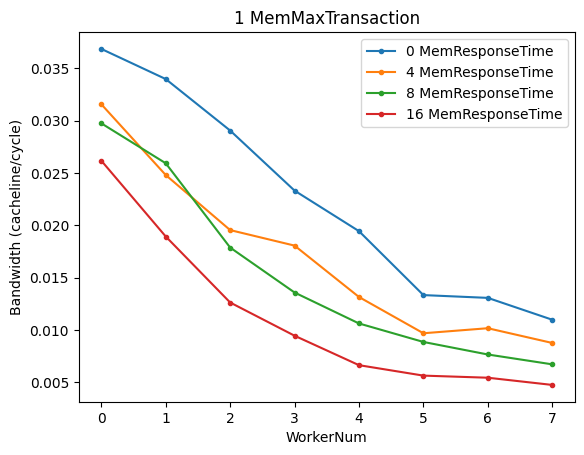

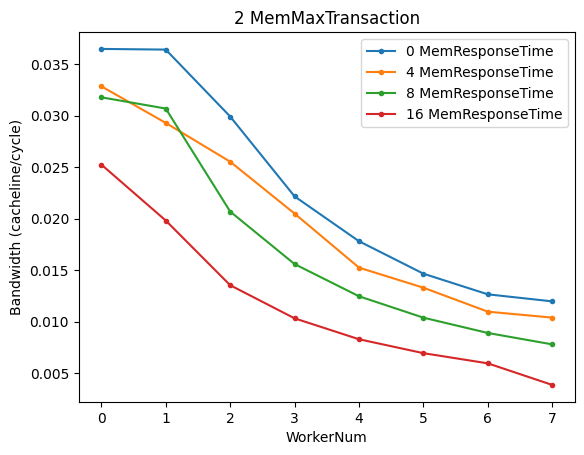

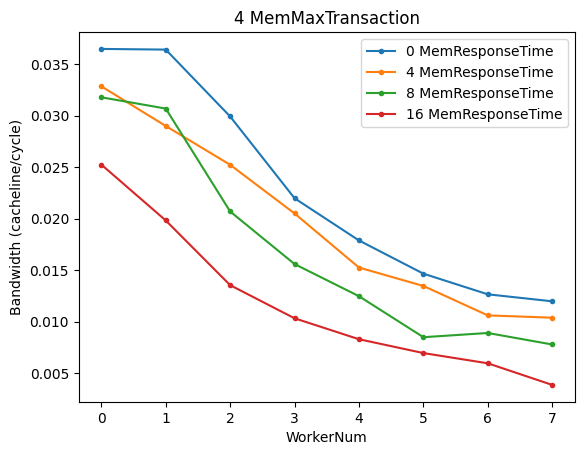

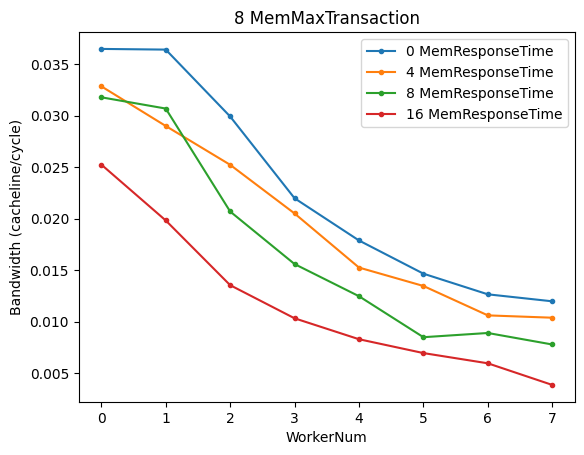

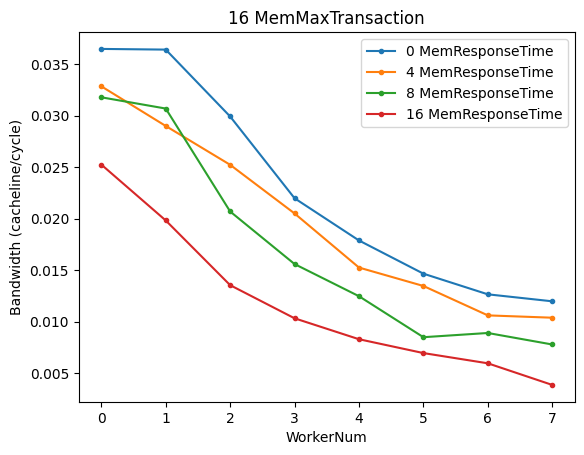

In [82]:
plot_benchmark(data, 'MemMaxTransaction', 'MemResponseTime')

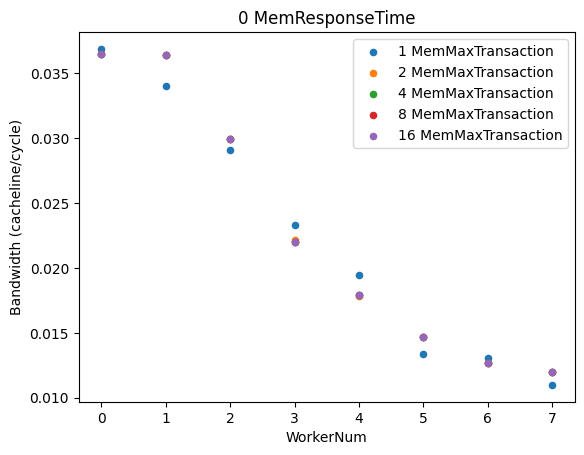

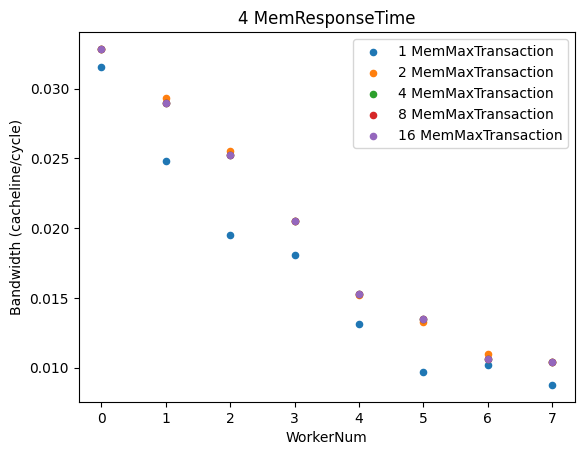

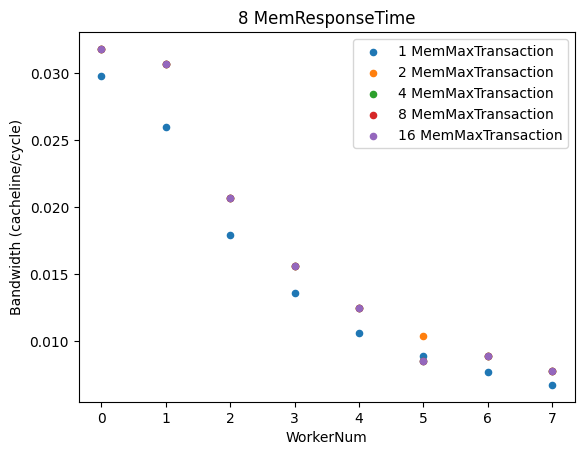

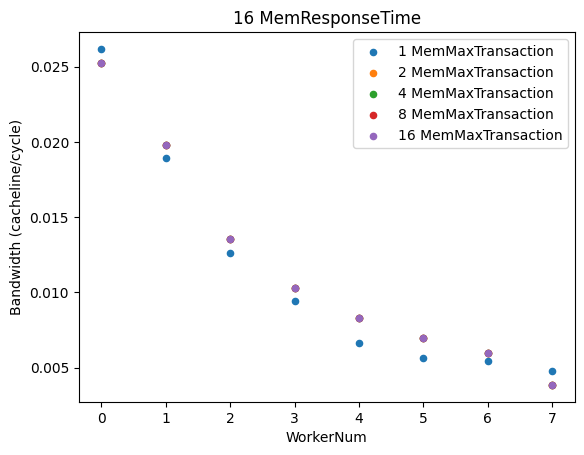

In [78]:
plot_benchmark(data, 'MemResponseTime', 'MemMaxTransaction')

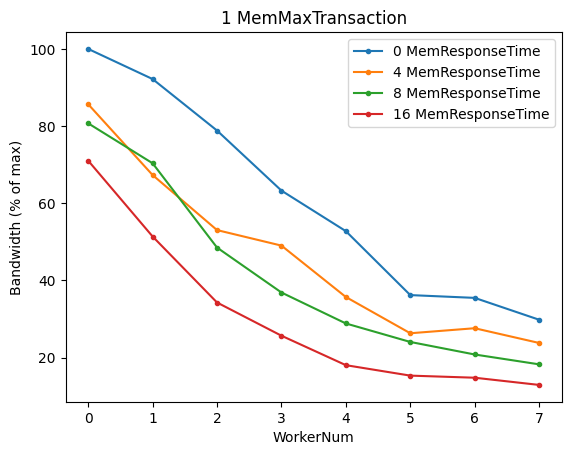

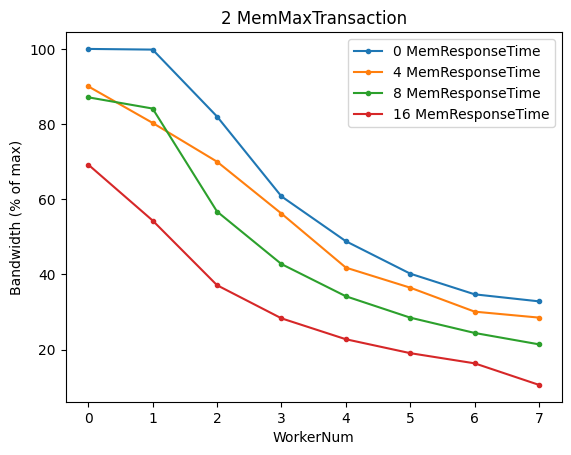

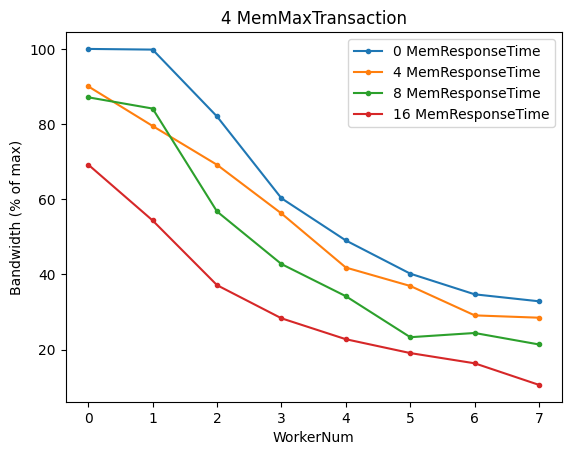

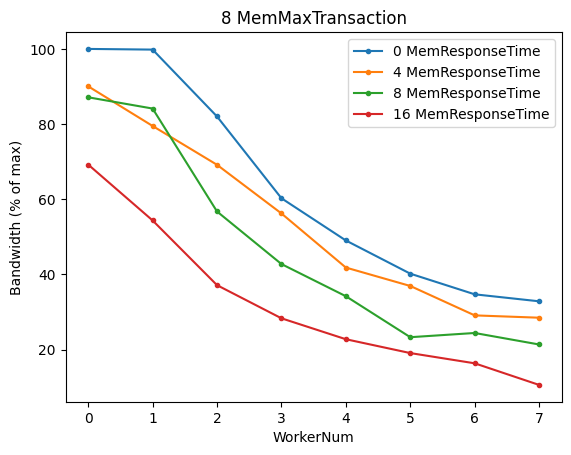

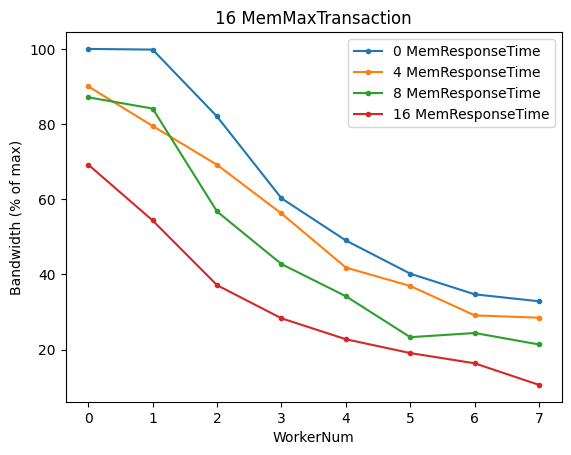

In [83]:
plot_normalized_benchmark(data, 'MemMaxTransaction', 'MemResponseTime')

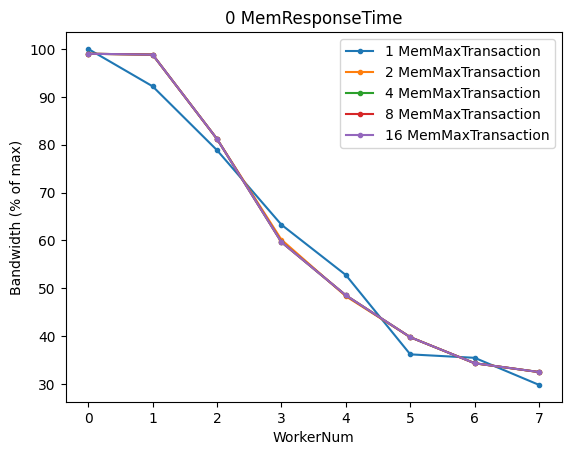

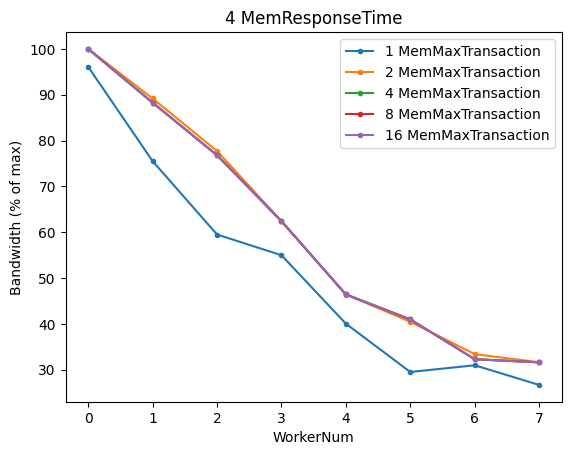

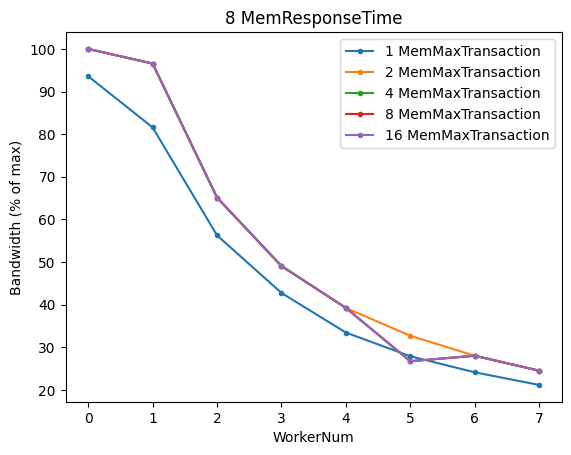

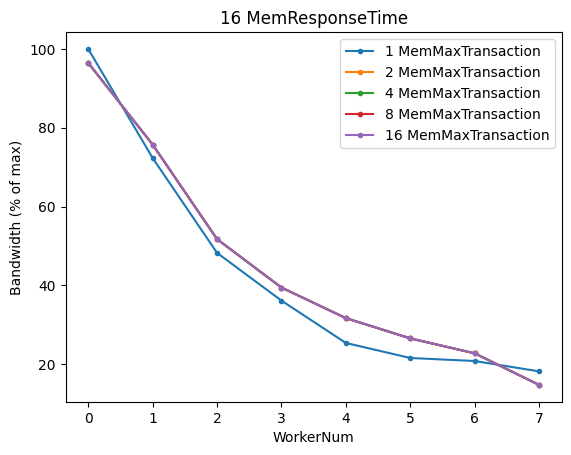

In [84]:
plot_normalized_benchmark(data, 'MemResponseTime', 'MemMaxTransaction')